In [249]:
from __future__ import print_function

import argparse
import os
import shutil
import time
import copy

import sys
sys.path.append("/ws/external")

# from models.cifar.allconv import AllConvNet
import numpy as np
from third_party.ResNeXt_DenseNet.models.densenet import densenet
from third_party.ResNeXt_DenseNet.models.resnext import resnext29
from third_party.WideResNet_pytorch.wideresnet import WideResNet
from third_party.WideResNet_pytorch.wideresnetproj import WideResNetProj
from third_party.WideResNet_pytorch.wideresnet_encoder import WideResNetEncoder
from third_party.supervised_contrastive_net import SupConNet
from models import MyDataParallel

import torch
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

from datasets import *
from datasets.mixdataset import BaseDataset, AugMixDataset
from torch.utils.data import Dataset

from feature_hook import FeatureHook
from utils import WandbLogger
# from apis import test, test_c, test_c_dg, Trainer

from collections import defaultdict
import pandas as pd

### Set argument

In [250]:
class Args():
    def __init__(self):
        self.dataset = 'cifar10'
        self.num_classes=10
        
        self.aug = 'augmix'
        self.model = 'wrn'
        self.epochs = 5
        self.batch_size = 8
        self.eval_batch_size = 10
        
        self.no_jsd = False
        self.additional_loss = 'jsd'
        self.temper = 1.0
        self.lambda_weight = 12.0
                
        # '/ws/data/log/cifar10/augmix_b512/model_best.pth.tar' # None '/ws/data/log/cifar10/augmix_b512/checkpoint.pth.tar'
        self.resume = "/ws/data/log/cifar10/baselines/augmix_b256_jsdv3_lw12/model_best.pth.tar" # "/ws/data/log/cifar10/baselines/pixmix_b256_jsd/model_best.pth.tar"
        #'/ws/data/log/cifar10/augmix_b512/model_best.pth.tar' # "/ws/data/log/cifar10/pixmix/pixmix_b512_jsdv3/model_best.pth.tar" # '/ws/data/log/cifar10/baselines/augmix_b512/checkpoint.pth.tar' # '/ws/data/log/cifar10/baseline_b512/checkpoint.pth.tar' # None # '/ws/data/log/cifar10/baselines/augmix_b512/checkpoint.pth.tar' # '/ws/data/log/cifar10/baseline_b512/checkpoint.pth.tar'
        
        
        self.evaluate = False
        self.analysis = True
        self.confusion_matrix = False
        self.save = '/ws/data/log/cifar10/augmix_b512' # None
        self.base_path = "/ws/data/cifar/CIFAR-10-C/"
        
        self.learning_rate = 0.001
        self.momentum = 0.9
        self.decay = 0.0005
        self.layers = 40
        self.widen_factor = 2
        self.droprate = 0.0
        self.mixture_width = 3
        self.mixture_depth = -1
        self.aug_severity = 3
        self.mixture_coefficient = 1.0
        
        self.reduction = 'batchmean'
        self.all_ops = 'all'
        self.num_workers = 0
        self.wandb_logger = None
        self.wandb = False
        
def get_lr(step, total_steps, lr_max, lr_min):
    """Compute learning rate according to cosine annealing schedule."""
    return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                               np.cos(step / total_steps * np.pi))

CORRUPTIONS = [
  'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
  'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
  'brightness', 'contrast', 'elastic_transform', 'pixelate',
  'jpeg_compression'
]

In [251]:
args = Args()

In [252]:
''' Load datasets '''
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4)])
preprocess = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5] * 3, [0.5] * 3)])
test_transform = preprocess

train_dataset = datasets.CIFAR10(
            '/ws/data/cifar', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(
    '/ws/data/cifar', train=False, transform=test_transform, download=True)
mixed_test_dataset = datasets.CIFAR10(
    '/ws/data/cifar', train=False, transform=None, download=True)
base_c_path = '/ws/data/cifar/CIFAR-10-C/'

train_dataset = AugMixDataset(train_dataset, preprocess, args.no_jsd,
                           args.all_ops, args.mixture_width, args.mixture_depth, args.aug_severity, args.mixture_coefficient)


train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=args.eval_batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [253]:
class ConcatDataset(Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets[0]

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

In [254]:
net = WideResNet(args.layers, args.num_classes, args.widen_factor, args.droprate)
net = MyDataParallel(net).cuda()
cudnn.benchmark = True
optimizer = torch.optim.SGD(
    net.parameters(),
    args.learning_rate,
    momentum=args.momentum,
    weight_decay=args.decay,
    nesterov=True)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, \
                                              lr_lambda=lambda step: get_lr(step, args.epochs * len(train_loader), 1,  1e-6 / args.learning_rate))  

if args.resume:
    if os.path.isfile(args.resume):
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('Model restored from epoch:', start_epoch)
    else:
        print('Model not found')

Model restored from epoch: 97


In [255]:
from torch.autograd import Variable
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)


In [256]:
def analysisv1_0(logits_clean, logits_aug1, logits_aug2=None, lambda_weight=12):

    B, C = logits_clean.size()
    
    if logits_aug2 == None:
        p_clean, p_aug1, = F.softmax(logits_clean, dim=1),\
                           F.softmax(logits_aug1, dim=1)

        # Clamp mixture distribution to avoid exploding KL divergence
        # jsd: batchmean reduction
        p_mixture = torch.clamp((p_clean + p_aug1) / 2., 1e-7, 1).log()
        jsd = (F.kl_div(p_mixture, p_clean, reduction='batchmean') + F.kl_div(p_mixture, p_aug1, reduction='batchmean')) / 2.
        jsd_mean = (F.kl_div(p_mixture, p_clean, reduction='mean') + F.kl_div(p_mixture, p_aug1, reduction='mean')) / 2.
        features = {'jsd_batchmean': jsd,
                    'p_clean': p_clean,
                    'p_aug1': p_aug1,+
                    'p_mixture': p_mixture,
                    }
    else:
        p_clean, p_aug1, p_aug2 = F.softmax(logits_clean, dim=1),\
                              F.softmax(logits_aug1, dim=1), \
                            F.softmax(logits_aug2, dim=1)

        # Clamp mixture distribution to avoid exploding KL divergence
        p_mixture = torch.clamp((p_clean + p_aug1 + p_aug2) / 3., 1e-7, 1).log()
        jsd = (F.kl_div(p_mixture, p_clean, reduction='batchmean') +
                        F.kl_div(p_mixture, p_aug1, reduction='batchmean') +
                        F.kl_div(p_mixture, p_aug2, reduction='batchmean')) / 3.
        
        # mse: mean reduction
        mse = (F.mse_loss(logits_clean, logits_aug1, reduction='sum') +
               F.mse_loss(logits_clean, logits_aug2, reduction='sum') +
               F.mse_loss(logits_aug1, logits_aug2, reduction='sum')) / 3 / B

        # cosine_similarity: mean reduction
        similarity = (F.cosine_similarity(logits_clean, logits_aug1) +
                      F.cosine_similarity(logits_clean, logits_aug2) +
                      F.cosine_similarity(logits_aug1, logits_aug2)) / 3 / B
        similarity = similarity.sum()


        features = {'jsd_batchmean': jsd,
                    'p_clean': p_clean,
                    'p_aug1': p_aug1,
                    'p_aug2': p_aug2,
                    'p_mixture': p_mixture,
                    }
    loss = jsd

    return loss, features

In [257]:
base_path = args.base_path

# load clean,npy

# test_c_features, test_c_mean_features = dict(), defaultdict(float)
# wandb_table = pd.DataFrame(columns=CORRUPTIONS, index=['loss', 'error'])
# confusion_matrices = []
import copy
original_test_dataset = copy.deepcopy(test_dataset)
original_test_dataset.data = np.load(base_path + 'clean' + '.npy')
original_test_dataset.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))

# load augmixed npy
# mixed_test_dataset = copy.deepcopy(mixed_test_dataset)
mixed_test_dataset = datasets.CIFAR10('/ws/data/cifar', train=False, transform=None, download=True)
mixed_test_dataset.data = np.load(base_path + 'clean' + '.npy')
mixed_test_dataset.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))
mixed_test_dataset = AugMixDataset(mixed_test_dataset, preprocess, True,
                                   args.all_ops, args.mixture_width, args.mixture_depth, args.aug_severity, 
                                   args.mixture_coefficient)


# load corruption npy
#corruption_accs = []
#        for corruption in CORRUPTIONS:

corruption = 'gaussian_noise'
corrupted_test_dataset = copy.deepcopy(test_dataset)
corrupted_test_dataset.data = np.load(base_path + corruption + '.npy')
corrupted_test_dataset.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))


# concatenate datasets
concat_dataset = ConcatDataset((original_test_dataset, 
                                mixed_test_dataset, 
                                corrupted_test_dataset))
test_loader = torch.utils.data.DataLoader(
    concat_dataset,
    batch_size=args.eval_batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True)

Files already downloaded and verified


In [258]:
net

MyDataParallel(
  (module): WideResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (block1): NetworkBlock(
      (layer): Sequential(
        (0): BasicBlock(
          (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (conv_shortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BasicBlock(
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

In [259]:
# hook
from feature_hook import FeatureHook


layer_list = []
for key, value in net.named_modules():
    layer_list.append(key)


hook = FeatureHook(layer_list)
hook.hook_multi_layer(net)

In [260]:
net.eval()
total_loss, total_correct = 0., 0.
wandb_features = dict()
confusion_matrix = torch.zeros(10, 10)
tsne_features = []
device = 'cuda'

In [261]:
with torch.no_grad():
#     clean_data, corrupted_data = next(iter(test_loader))
#     clean_data, corrupted_data = next(iter(test_loader))
#     clean_data, corrupted_data = next(iter(test_loader))
#     clean_data, corrupted_data = next(iter(test_loader))
#         if i == 50000 / args.eval_batch_size -2: 
#     for i, (clean_data, mixed_data, corrupted_data) in reversed(list(enumerate(test_loader))):
    for i, (clean_data, mixed_data, corrupted_data) in enumerate(test_loader):
        if i==50000 / args.eval_batch_size -2:
            net.module.hook_features.clear()
            
            clean_images, _ = clean_data
            mixed_images, _ = mixed_data
            corrupted_images, targets = corrupted_data
            images_all = torch.cat([clean_images, mixed_images, corrupted_images], 0).to(device)
            # targets_all = torch.cat([targets, targets], 0).to(self.device)
            targets = targets.to(device)

            logits_all = net(images_all)
            logits, logits_mixed, logits_corrupted = torch.chunk(logits_all, 3)
            additional_loss, feature = analysisv1_0(logits, logits_mixed, logits_corrupted, lambda_weight=12)
                
            for hkey, hfeature in net.module.hook_features.items():
                B = clean_images.size(0)
                feature_clean, feature_aug1, feature_aug2 = torch.chunk(hfeature[0], 3)
                feature_clean, feature_aug1, feature_aug2 = feature_clean.view(B, -1), feature_aug1.view(B, -1), feature_aug2.view(B, -1)
                hook_additional_loss, hook_feature = analysisv1_0(feature_clean, feature_aug1, feature_aug2, lambda_weight=12)
                for key, value in hook_feature.items():
                    new_key = f'{hkey}_{key}'
                    feature[new_key] = value.detach()
            
            
            loss = F.cross_entropy(logits, targets)
            loss_mixed = F.cross_entropy(logits_mixed, targets)
            loss_corrupted = F.cross_entropy(logits_corrupted, targets)
            pred = logits.data.max(1)[1]
            pred_mixed = logits_mixed.data.max(1)[1]
            pred_corrupted = logits_corrupted.data.max(1)[1]
            correct = pred.eq(targets.data).sum().item()
            correct_mixed = pred_mixed.eq(targets.data).sum().item()
            correct_corrupted = pred_corrupted.eq(targets.data).sum().item()



#     total_loss += float(loss.data)
#     total_correct += pred.eq(targets.data).sum().item()
    

In [262]:
# net.module.hook_features.keys()

In [263]:
def _ssimv2(img1, img2, window, window_size, channel, size_average=True, return_numpy=True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2
    
    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma1 = sigma1_sq.pow(1/2)
    sigma2 = sigma2_sq.pow(1/2)
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2
    
#     print("sigma1: ", sigma1)
    luminance = (2*mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)
    contrast = (2*sigma1*sigma2 + C2) / (sigma1_sq + sigma2_sq + C2)
    structure = (2*sigma12 + C2) / (2*sigma1*sigma2 + C2)
    
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    
    if return_numpy:
        ssim_map = ssim_map.detach().cpu().numpy()
        luminance = luminance.detach().cpu().numpy()
        contrast =  contrast.detach().cpu().numpy()
        structure = structure.detach().cpu().numpy()
    
    if size_average:
        return ssim_map.mean(), luminance.mean(), contrast.mean(), structure.mean()
    else:
        return ssim_map, luminance, contrast, structure
    

def ssimv2(img1, img2, window_size=3, size_average=True, return_numpy=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssimv2(img1, img2, window, window_size, channel, size_average)

In [264]:
def analyzie_ssims(net, topic='relu', channel_mean=True, plot=True, figsize=(10,10), log=False):
    '''
    topic: 'module': plot all features, 'relu': plot relu features, 'block.1': plot block1 features
    '''
    import matplotlib.pyplot as plt
    hkeys = []
    
    ssims = []
    luminances = []
    contrasts = []
    structures = []

    ssims2 = []
    luminances2 = []
    contrasts2 = []
    structures2 = []

    for hkey, hfeature in net.module.hook_features.items():
        if hfeature[0].dim() == 2:
            continue
        if topic in hkey:
#             hkey = ''.join([i+"_" for i in hkey if i.isdigit()])
            hkeys.append(hkey)            
            
            features_clean, features_mixed, features_corrupted = torch.chunk(hfeature[0], 3)
            
            if channel_mean:
                features_clean = features_clean.mean(dim=1, keepdim=True)
                features_mixed = features_mixed.mean(dim=1, keepdim=True)
                features_corrupted = features_corrupted.mean(dim=1, keepdim=True)
            
            B, C, H, W = features_clean.size()

#             window_size= int(7*H/32)
            window_size=int(8*H/32)
            ssim, luminance, contrast, structure = ssimv2(features_clean, features_mixed, window_size, size_average=True)

            ssims.append(ssim)
            luminances.append(luminance)
            contrasts.append(contrast)
            structures.append(structure)

            ssim2, luminance2, contrast2, structure2 = ssimv2(features_clean, features_corrupted, window_size, size_average=True)

            ssims2.append(ssim2)
            luminances2.append(luminance2)
            contrasts2.append(contrast2)
            structures2.append(structure2)
            
            if log:
                print("shape: ", features_clean.size())
                print(f"mixed features/{hkey}/ssim: {ssim:.4f}, luminance: {luminance:.4f}, contrast: {contrast:.4f}, structure: {structure:.4f}\n")
                print(f"corrupted features/{hkey}/ssim2: {ssim2:.4f}, luminance2: {luminance2:.4f}, contrast2: {contrast2:.4f}, structure2: {structure2:.4f}\n")
            
    if plot:
        plt.figure(figsize=figsize)
        x = np.arange(len(hkeys))

        plt.xticks(x, rotation=45)

        plt.plot(ssims, 'k-', label='ssims')
        plt.plot(luminances, 'r-', label='luminances')
        plt.plot(contrasts, 'g-', label='contrasts')
        plt.plot(structures, 'b-', label='structures')
        plt.plot(ssims2, 'k--', label='ssims2')
        plt.plot(luminances2, 'r--', label='luminances2')
        plt.plot(contrasts2, 'g--', label='contrasts2')
        plt.plot(structures2, 'b--', label='structures2')

        plt.title(topic)
        plt.legend()
        plt.show()
        
        for i, hkey in enumerate(hkeys):
            print(f"{i}: {hkey}")


                


In [265]:
def analysisv1_0(logits_clean, logits_aug1, logits_aug2=None, lambda_weight=12, return_numpy=True):

    B, C = logits_clean.size()

    p_clean, p_aug1, = F.softmax(logits_clean, dim=1),\
                       F.softmax(logits_aug1, dim=1)

    # Clamp mixture distribution to avoid exploding KL divergence
    # jsd: batchmean reduction
    p_mixture = torch.clamp((p_clean + p_aug1) / 2., 1e-7, 1).log()
    jsd = lambda_weight * (F.kl_div(p_mixture, p_clean, reduction='batchmean') + F.kl_div(p_mixture, p_aug1, reduction='batchmean')) / 2.
    kl = lambda_weight * torch.abs(F.kl_div(p_clean, p_aug1))
    
    # mse: mean reduction
    mse = lambda_weight * (F.mse_loss(logits_clean, logits_aug1, reduction='mean')) / B

    # cosine_similarity: mean reduction
    similarity = F.cosine_similarity(logits_clean, logits_aug1)
    similarity = similarity.mean()
    
    if return_numpy:
        jsd = jsd.detach().cpu().numpy()
        mse = mse.detach().cpu().numpy()
        similarity = similarity.detach().cpu().numpy()
        kl = kl.detach().cpu().numpy()

    features = {'jsd': jsd,
                'mse': mse,
                'kl': kl,
                'similarity': similarity,
                'p_clean': p_clean,
                'p_aug1': p_aug1,
                'p_mixture': p_mixture,
                
                }
    loss = jsd

    return loss, features

In [266]:
def analyze_jsd(net, topic='relu', channel_mean=True, plot=True, figsize=(10,10), log=False, lw=12):
    '''
    topic: 'module': plot all features, 'relu': plot relu features, 'block.1': plot block1 features
    '''
    import matplotlib.pyplot as plt
    hkeys = []
    
    mses = []
    similarities = []
    jsds = []
    kls = []

    mses2 = []
    similarities2 = []
    jsds2 = []
    kls2 = []

    for hkey, hfeature in net.module.hook_features.items():

        if topic in hkey or 'fc' in hkey or 'avgpool' in hkey:
            hkeys.append(hkey)            
            
            features_clean, features_mixed, features_corrupted = torch.chunk(hfeature[0], 3)
            
            if channel_mean:
                features_clean = features_clean.mean(dim=1, keepdim=True)
                features_mixed = features_mixed.mean(dim=1, keepdim=True)
                features_corrupted = features_corrupted.mean(dim=1, keepdim=True)
            
            # apply 2D gaussian convolutional filter?
#             window_size=int(8*H/32)
            
            # reshape to (B, -1)
            if hfeature[0].dim() != 2:
                B, C, H, W = features_clean.size()
                features_clean = features_clean.view(B, -1)
                features_mixed = features_mixed.view(B, -1)
                features_corrupted = features_corrupted.view(B, -1)
            
                
#             features_clean, features_mixed, features_corrupted = features_clean.view(B, -1), features_mixed.view(B, -1), features_corrupted(B, -1)
            
            
            _, features = analysisv1_0(features_clean, features_mixed, lambda_weight=lw)
            
            mses.append(features['mse'])
            similarities.append(features['similarity'])
            jsds.append(features['jsd'])
            kls.append(features['kl'])
            
            _, features2 = analysisv1_0(features_clean, features_corrupted, lambda_weight=lw)
            
            mses2.append(features2['mse'])
            similarities2.append(features2['similarity'])
            jsds2.append(features2['jsd'])
            kls2.append(features2['kl'])

            
            if log:
                print("shape: ", features_clean.size())
                print(f"mixed features/{hkey}/ssim: {ssim:.4f}, luminance: {luminance:.4f}, contrast: {contrast:.4f}, structure: {structure:.4f}\n")
                print(f"corrupted features/{hkey}/ssim2: {ssim2:.4f}, luminance2: {luminance2:.4f}, contrast2: {contrast2:.4f}, structure2: {structure2:.4f}\n")
            
    if plot:
        plt.figure(figsize=figsize)
        x = np.arange(len(hkeys))

        plt.xticks(x, rotation=45)

        plt.plot(jsds, 'k-', label='jsds')
        plt.plot(mses, 'r-', label='mses')
#         plt.plot(kls, 'g-', label='kls')
        plt.plot(similarities, 'b-', label='similarities')
        plt.plot(jsds2, 'k--', label='jsds2')
        plt.plot(mses2, 'r--', label='mses2')
#         plt.plot(kls2, 'g--', label='kls2')
        plt.plot(similarities2, 'b--', label='similarities2')

        plt.title(topic)
        plt.legend()
        plt.show()
        
        for i, hkey in enumerate(hkeys):
            print(f"{i}: {hkey}")

### analyze jsd

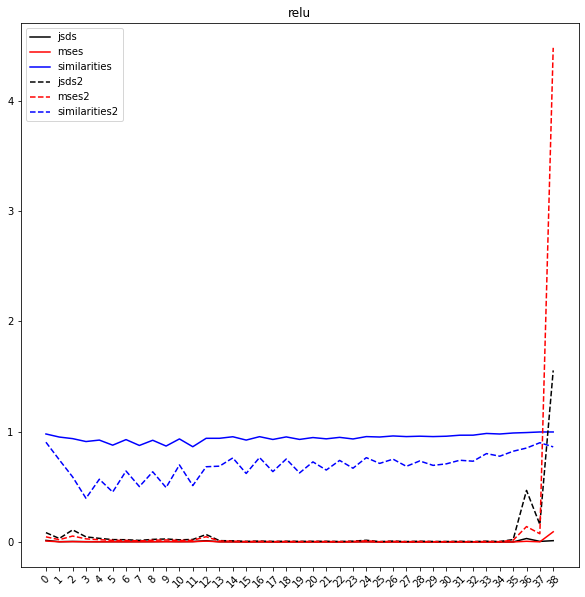

0: module.block1.layer.0.relu1
1: module.block1.layer.0.relu2
2: module.block1.layer.1.relu1
3: module.block1.layer.1.relu2
4: module.block1.layer.2.relu1
5: module.block1.layer.2.relu2
6: module.block1.layer.3.relu1
7: module.block1.layer.3.relu2
8: module.block1.layer.4.relu1
9: module.block1.layer.4.relu2
10: module.block1.layer.5.relu1
11: module.block1.layer.5.relu2
12: module.block2.layer.0.relu1
13: module.block2.layer.0.relu2
14: module.block2.layer.1.relu1
15: module.block2.layer.1.relu2
16: module.block2.layer.2.relu1
17: module.block2.layer.2.relu2
18: module.block2.layer.3.relu1
19: module.block2.layer.3.relu2
20: module.block2.layer.4.relu1
21: module.block2.layer.4.relu2
22: module.block2.layer.5.relu1
23: module.block2.layer.5.relu2
24: module.block3.layer.0.relu1
25: module.block3.layer.0.relu2
26: module.block3.layer.1.relu1
27: module.block3.layer.1.relu2
28: module.block3.layer.2.relu1
29: module.block3.layer.2.relu2
30: module.block3.layer.3.relu1
31: module.block3.

In [267]:
analyze_jsd(net, topic='relu', channel_mean=False, plot=True, log=False, lw=12)

In [268]:
# analyze_jsd(net, topic='bn', channel_mean=False, plot=True, log=False, lw=24)

In [269]:
# analyze_jsd(net, topic='conv', channel_mean=False, plot=True, log=False, lw=24)

In [270]:
# analyze_jsd(net, topic='block1', channel_mean=False, plot=True, log=False, lw=24)

### analyzie ssims

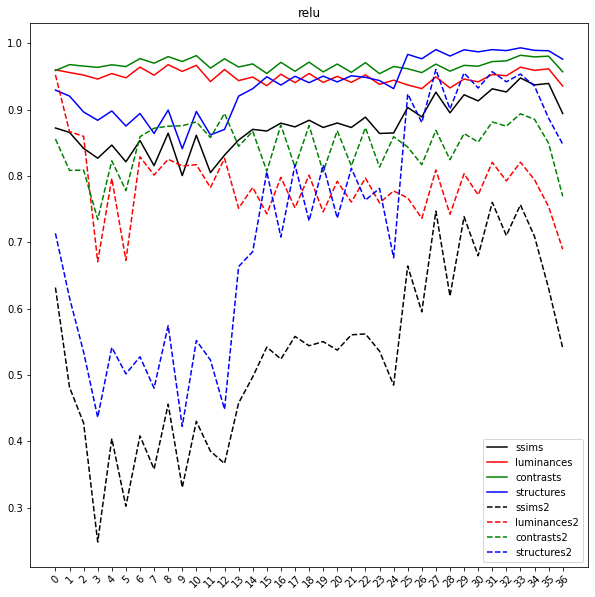

0: module.block1.layer.0.relu1
1: module.block1.layer.0.relu2
2: module.block1.layer.1.relu1
3: module.block1.layer.1.relu2
4: module.block1.layer.2.relu1
5: module.block1.layer.2.relu2
6: module.block1.layer.3.relu1
7: module.block1.layer.3.relu2
8: module.block1.layer.4.relu1
9: module.block1.layer.4.relu2
10: module.block1.layer.5.relu1
11: module.block1.layer.5.relu2
12: module.block2.layer.0.relu1
13: module.block2.layer.0.relu2
14: module.block2.layer.1.relu1
15: module.block2.layer.1.relu2
16: module.block2.layer.2.relu1
17: module.block2.layer.2.relu2
18: module.block2.layer.3.relu1
19: module.block2.layer.3.relu2
20: module.block2.layer.4.relu1
21: module.block2.layer.4.relu2
22: module.block2.layer.5.relu1
23: module.block2.layer.5.relu2
24: module.block3.layer.0.relu1
25: module.block3.layer.0.relu2
26: module.block3.layer.1.relu1
27: module.block3.layer.1.relu2
28: module.block3.layer.2.relu1
29: module.block3.layer.2.relu2
30: module.block3.layer.3.relu1
31: module.block3.

In [271]:
analyzie_ssims(net, topic='relu', channel_mean=False, plot=True, log=False)

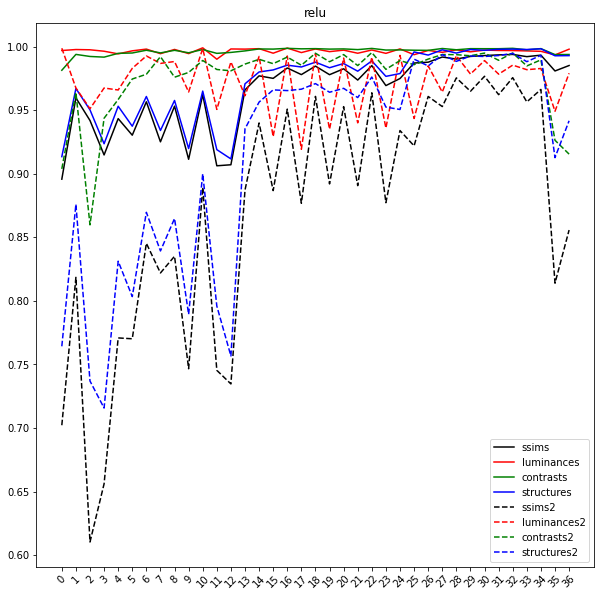

0: module.block1.layer.0.relu1
1: module.block1.layer.0.relu2
2: module.block1.layer.1.relu1
3: module.block1.layer.1.relu2
4: module.block1.layer.2.relu1
5: module.block1.layer.2.relu2
6: module.block1.layer.3.relu1
7: module.block1.layer.3.relu2
8: module.block1.layer.4.relu1
9: module.block1.layer.4.relu2
10: module.block1.layer.5.relu1
11: module.block1.layer.5.relu2
12: module.block2.layer.0.relu1
13: module.block2.layer.0.relu2
14: module.block2.layer.1.relu1
15: module.block2.layer.1.relu2
16: module.block2.layer.2.relu1
17: module.block2.layer.2.relu2
18: module.block2.layer.3.relu1
19: module.block2.layer.3.relu2
20: module.block2.layer.4.relu1
21: module.block2.layer.4.relu2
22: module.block2.layer.5.relu1
23: module.block2.layer.5.relu2
24: module.block3.layer.0.relu1
25: module.block3.layer.0.relu2
26: module.block3.layer.1.relu1
27: module.block3.layer.1.relu2
28: module.block3.layer.2.relu1
29: module.block3.layer.2.relu2
30: module.block3.layer.3.relu1
31: module.block3.

In [67]:
analyzie_ssims(net, topic='relu', channel_mean=True, plot=True, log=False)

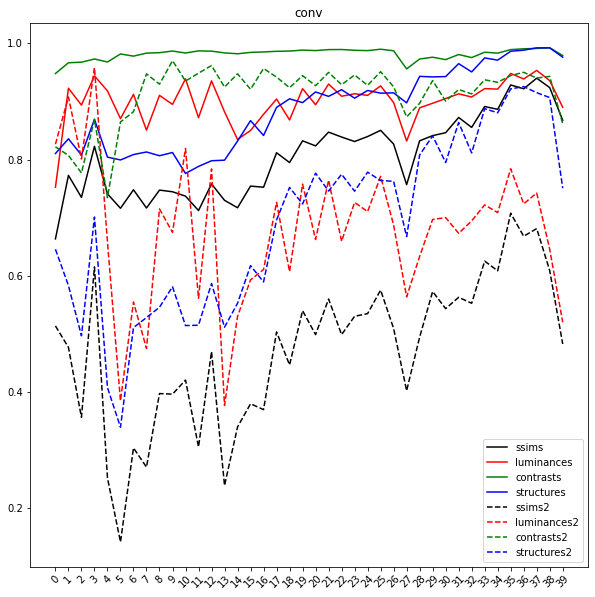

0: module.conv1
1: module.block1.layer.0.conv1
2: module.block1.layer.0.conv2
3: module.block1.layer.0.conv_shortcut
4: module.block1.layer.1.conv1
5: module.block1.layer.1.conv2
6: module.block1.layer.2.conv1
7: module.block1.layer.2.conv2
8: module.block1.layer.3.conv1
9: module.block1.layer.3.conv2
10: module.block1.layer.4.conv1
11: module.block1.layer.4.conv2
12: module.block1.layer.5.conv1
13: module.block1.layer.5.conv2
14: module.block2.layer.0.conv1
15: module.block2.layer.0.conv2
16: module.block2.layer.0.conv_shortcut
17: module.block2.layer.1.conv1
18: module.block2.layer.1.conv2
19: module.block2.layer.2.conv1
20: module.block2.layer.2.conv2
21: module.block2.layer.3.conv1
22: module.block2.layer.3.conv2
23: module.block2.layer.4.conv1
24: module.block2.layer.4.conv2
25: module.block2.layer.5.conv1
26: module.block2.layer.5.conv2
27: module.block3.layer.0.conv1
28: module.block3.layer.0.conv2
29: module.block3.layer.0.conv_shortcut
30: module.block3.layer.1.conv1
31: modul

In [68]:
analyzie_ssims(net, topic='conv', channel_mean=False, plot=True, log=False)

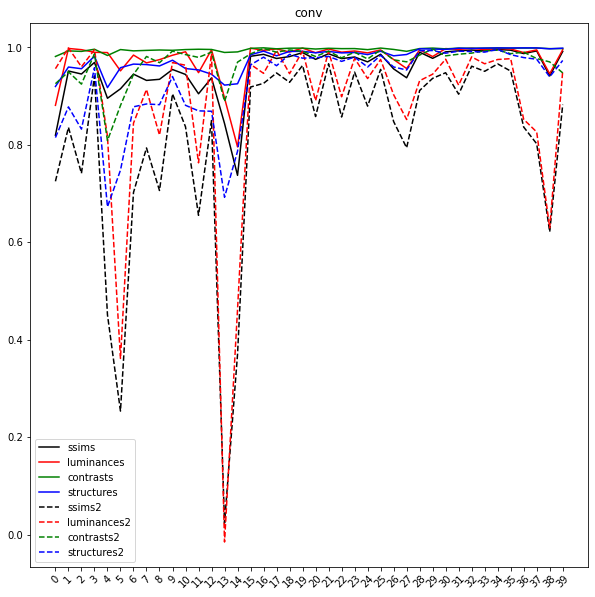

0: module.conv1
1: module.block1.layer.0.conv1
2: module.block1.layer.0.conv2
3: module.block1.layer.0.conv_shortcut
4: module.block1.layer.1.conv1
5: module.block1.layer.1.conv2
6: module.block1.layer.2.conv1
7: module.block1.layer.2.conv2
8: module.block1.layer.3.conv1
9: module.block1.layer.3.conv2
10: module.block1.layer.4.conv1
11: module.block1.layer.4.conv2
12: module.block1.layer.5.conv1
13: module.block1.layer.5.conv2
14: module.block2.layer.0.conv1
15: module.block2.layer.0.conv2
16: module.block2.layer.0.conv_shortcut
17: module.block2.layer.1.conv1
18: module.block2.layer.1.conv2
19: module.block2.layer.2.conv1
20: module.block2.layer.2.conv2
21: module.block2.layer.3.conv1
22: module.block2.layer.3.conv2
23: module.block2.layer.4.conv1
24: module.block2.layer.4.conv2
25: module.block2.layer.5.conv1
26: module.block2.layer.5.conv2
27: module.block3.layer.0.conv1
28: module.block3.layer.0.conv2
29: module.block3.layer.0.conv_shortcut
30: module.block3.layer.1.conv1
31: modul

In [69]:
analyzie_ssims(net, topic='conv', channel_mean=True, plot=True, log=False)

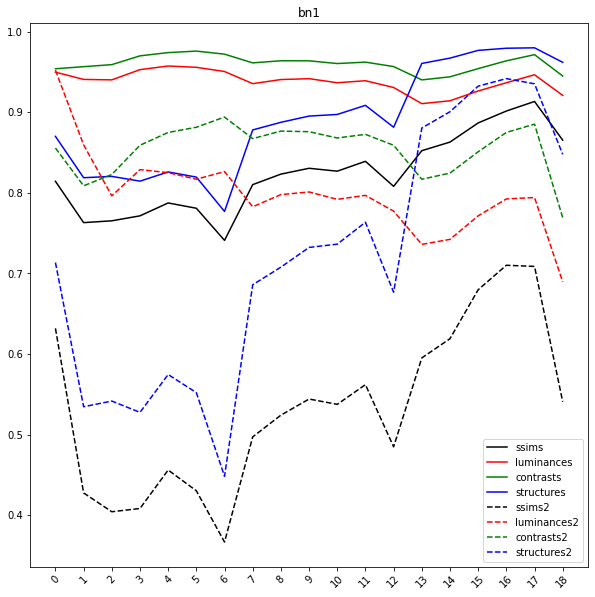

0: module.block1.layer.0.bn1
1: module.block1.layer.1.bn1
2: module.block1.layer.2.bn1
3: module.block1.layer.3.bn1
4: module.block1.layer.4.bn1
5: module.block1.layer.5.bn1
6: module.block2.layer.0.bn1
7: module.block2.layer.1.bn1
8: module.block2.layer.2.bn1
9: module.block2.layer.3.bn1
10: module.block2.layer.4.bn1
11: module.block2.layer.5.bn1
12: module.block3.layer.0.bn1
13: module.block3.layer.1.bn1
14: module.block3.layer.2.bn1
15: module.block3.layer.3.bn1
16: module.block3.layer.4.bn1
17: module.block3.layer.5.bn1
18: module.bn1


In [70]:
analyzie_ssims(net, topic='bn1', channel_mean=False, plot=True, log=False)

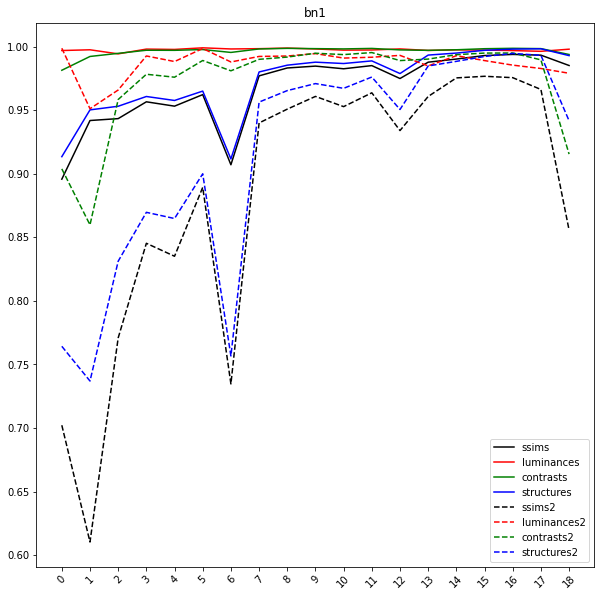

0: module.block1.layer.0.bn1
1: module.block1.layer.1.bn1
2: module.block1.layer.2.bn1
3: module.block1.layer.3.bn1
4: module.block1.layer.4.bn1
5: module.block1.layer.5.bn1
6: module.block2.layer.0.bn1
7: module.block2.layer.1.bn1
8: module.block2.layer.2.bn1
9: module.block2.layer.3.bn1
10: module.block2.layer.4.bn1
11: module.block2.layer.5.bn1
12: module.block3.layer.0.bn1
13: module.block3.layer.1.bn1
14: module.block3.layer.2.bn1
15: module.block3.layer.3.bn1
16: module.block3.layer.4.bn1
17: module.block3.layer.5.bn1
18: module.bn1


In [71]:
analyzie_ssims(net, topic='bn1', channel_mean=True, plot=True, log=False)

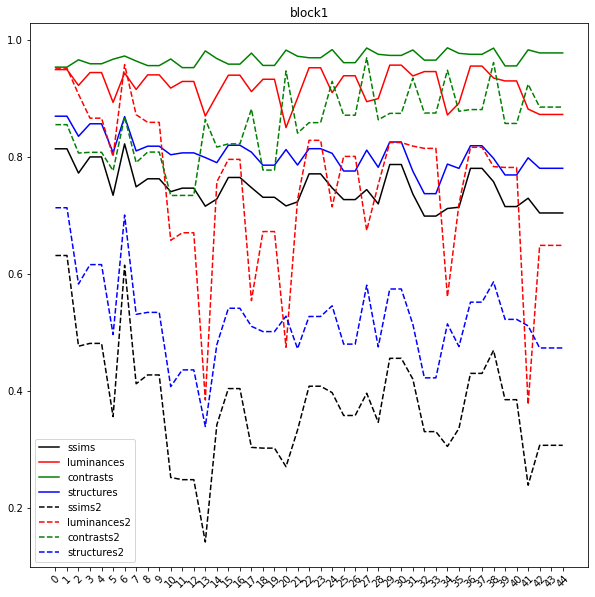

0: module.block1.layer.0.bn1
1: module.block1.layer.0.relu1
2: module.block1.layer.0.conv1
3: module.block1.layer.0.bn2
4: module.block1.layer.0.relu2
5: module.block1.layer.0.conv2
6: module.block1.layer.0.conv_shortcut
7: module.block1.layer.0
8: module.block1.layer.1.bn1
9: module.block1.layer.1.relu1
10: module.block1.layer.1.conv1
11: module.block1.layer.1.bn2
12: module.block1.layer.1.relu2
13: module.block1.layer.1.conv2
14: module.block1.layer.1
15: module.block1.layer.2.bn1
16: module.block1.layer.2.relu1
17: module.block1.layer.2.conv1
18: module.block1.layer.2.bn2
19: module.block1.layer.2.relu2
20: module.block1.layer.2.conv2
21: module.block1.layer.2
22: module.block1.layer.3.bn1
23: module.block1.layer.3.relu1
24: module.block1.layer.3.conv1
25: module.block1.layer.3.bn2
26: module.block1.layer.3.relu2
27: module.block1.layer.3.conv2
28: module.block1.layer.3
29: module.block1.layer.4.bn1
30: module.block1.layer.4.relu1
31: module.block1.layer.4.conv1
32: module.block1.la

In [72]:
analyzie_ssims(net, topic='block1', channel_mean=False, plot=True, log=False)

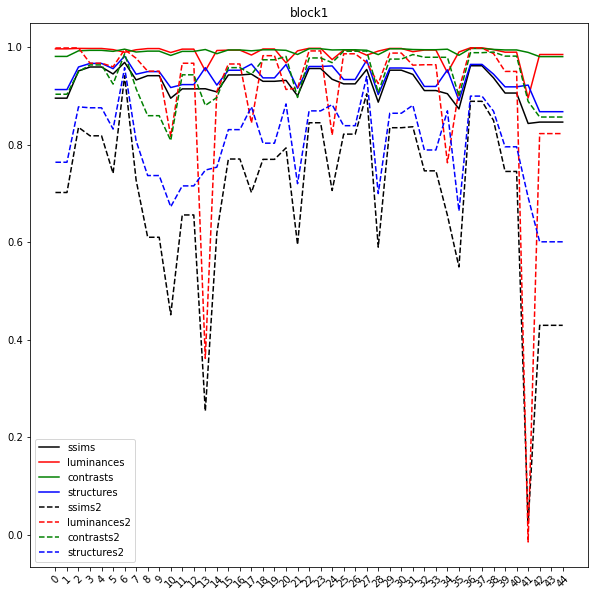

0: module.block1.layer.0.bn1
1: module.block1.layer.0.relu1
2: module.block1.layer.0.conv1
3: module.block1.layer.0.bn2
4: module.block1.layer.0.relu2
5: module.block1.layer.0.conv2
6: module.block1.layer.0.conv_shortcut
7: module.block1.layer.0
8: module.block1.layer.1.bn1
9: module.block1.layer.1.relu1
10: module.block1.layer.1.conv1
11: module.block1.layer.1.bn2
12: module.block1.layer.1.relu2
13: module.block1.layer.1.conv2
14: module.block1.layer.1
15: module.block1.layer.2.bn1
16: module.block1.layer.2.relu1
17: module.block1.layer.2.conv1
18: module.block1.layer.2.bn2
19: module.block1.layer.2.relu2
20: module.block1.layer.2.conv2
21: module.block1.layer.2
22: module.block1.layer.3.bn1
23: module.block1.layer.3.relu1
24: module.block1.layer.3.conv1
25: module.block1.layer.3.bn2
26: module.block1.layer.3.relu2
27: module.block1.layer.3.conv2
28: module.block1.layer.3
29: module.block1.layer.4.bn1
30: module.block1.layer.4.relu1
31: module.block1.layer.4.conv1
32: module.block1.la

In [73]:
analyzie_ssims(net, topic='block1', channel_mean=True, plot=True, log=False)

In [74]:
# analyzie_ssims(net, topic='module', channel_mean=False, plot=True, log=False)

### plot feature maps

In [ ]:
import matplotlib.pyplot as plt
def plot_images(images, batch_size=8):
    images = images.detach().cpu().numpy()
    images = images.transpose(0, 2, 3, 1)

    fig = plt.figure(figsize=(8, batch_size))
    for i in range(0, batch_size):
        fig.add_subplot(1, batch_size, i+1)
        plt.imshow(images[i])
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



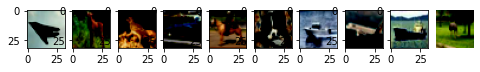

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

pred: tensor([0, 4, 6, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([ 9.3381,  8.9561,  7.3479,  9.2557, 10.9876,  8.1394,  8.1608,  9.2554,
         9.8064,  6.7077], device='cuda:0')
correct: tensor([ True,  True, False,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')



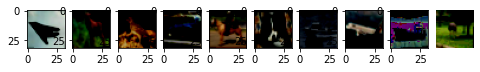

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

pred_mixed: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits_mixed: tensor([ 9.4176,  9.2218,  6.7277,  9.3512, 11.1222,  9.0061,  8.4801,  9.3077,
        10.2034,  7.0473], device='cuda:0')
correct_mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')



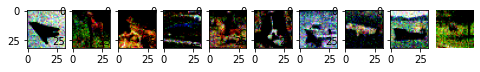

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

pred_corrupted: tensor([0, 4, 6, 0, 4, 5, 0, 0, 8, 4], device='cuda:0')

logits_corrupted: tensor([ 9.8146,  9.2987, 10.7751,  6.7983,  8.0567,  6.5528,  6.2423,  8.4089,
        10.8324,  7.9047], device='cuda:0')
correct_corrupted: tensor([ True,  True, False,  True, False,  True, False,  True,  True, False],
       device='cuda:0')



In [246]:
print("class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck \n")
plot_images(clean_images, batch_size=args.eval_batch_size)

print(f"target: {targets}\n",)
print(f"pred: {pred}\n")
print(f"logits: {logits.max(1)[0]}")
correct = pred.eq(targets.data)
print(f"correct: {correct}\n")

plot_images(mixed_images, batch_size=args.eval_batch_size)
print(f"target: {targets}\n",)
print(f"pred_mixed: {pred_mixed}\n")
print(f"logits_mixed: {logits_mixed.max(1)[0]}")
correct_mixed = pred_mixed.eq(targets.data)
print(f"correct_mixed: {correct_mixed}\n")

plot_images(corrupted_images, batch_size=args.eval_batch_size)
print(f"target: {targets}\n",)
print(f"pred_corrupted: {pred_corrupted}\n")
print(f"logits_corrupted: {logits_corrupted.max(1)[0]}")
correct_corrupted = pred_corrupted.eq(targets.data)
print(f"correct_corrupted: {correct_corrupted}\n")


In [29]:
def plot_features(net, topic='relu', log=False):
    for key, features_all in net.module.hook_features.items():
        if topic in key:
            features_all = features_all[0].mean(dim=1, keepdim=True)
            features_clean, features_mixed, features_corrupted = torch.chunk(features_all, 3)
            print(f"target: {targets}\n",)
            print("class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck \n")
            plot_images(features_clean, batch_size=args.eval_batch_size)
            print(f"pred: {pred}\n")
            print(f"logits: {logits.max(1)[0]}")
            correct = pred.eq(targets.data)
            print(f"correct: {correct}\n")

            print(f"target: {targets}\n",)
            print("class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck \n")
            plot_images(features_mixed, batch_size=args.eval_batch_size)
            print(f"pred: {pred_mixed}\n")
            print(f"logits: {logits.max(1)[0]}")
            correct = pred.eq(targets.data)
            print(f"mixed: {correct_mixed}\n")

            print(f"target: {targets}\n",)
            print("class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck \n")
            plot_images(features_corrupted, batch_size=args.eval_batch_size)
            print(f"pred: {pred}\n")
            print(f"logits: {logits_corrupted.max(1)[0]}")
            correct = pred.eq(targets.data)
            print(f"corrupted: {correct_corrupted}\n")

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



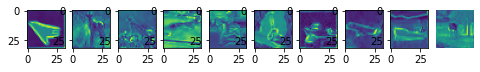

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



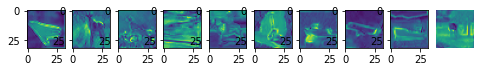

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



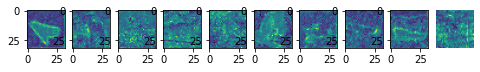

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



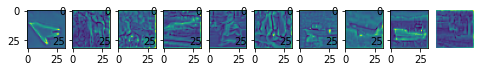

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



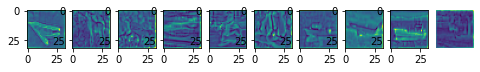

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



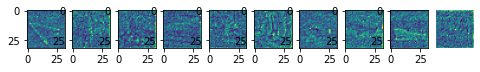

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



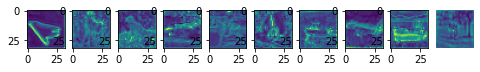

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



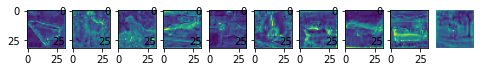

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



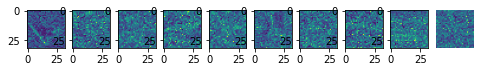

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



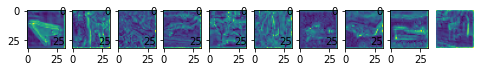

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



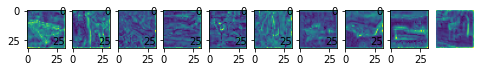

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



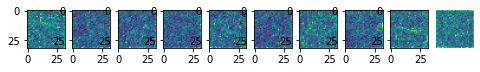

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



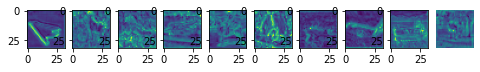

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



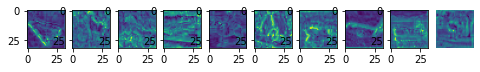

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



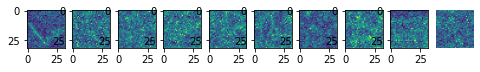

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



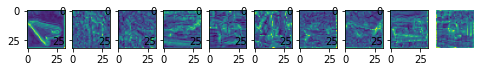

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



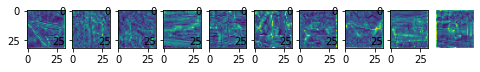

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



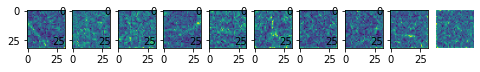

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



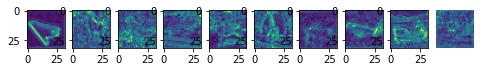

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



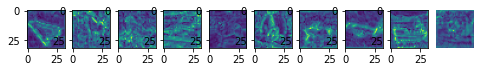

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



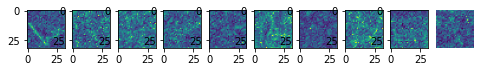

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



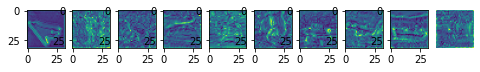

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



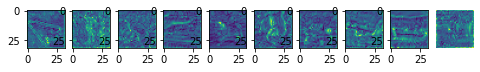

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



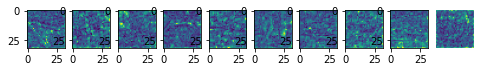

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



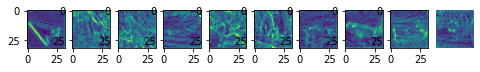

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



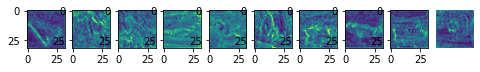

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



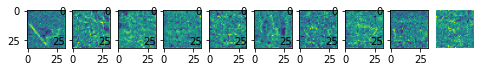

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



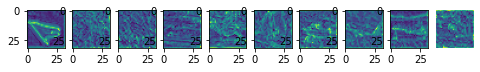

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



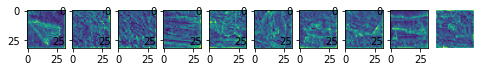

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



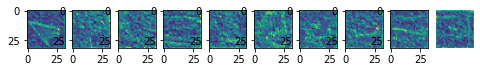

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



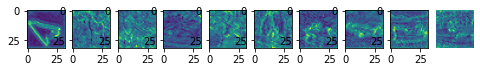

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



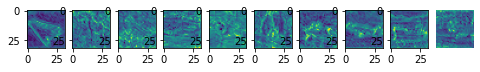

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



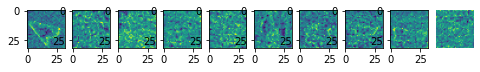

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



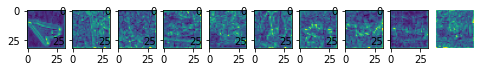

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



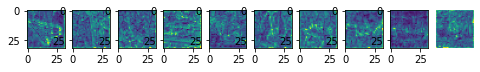

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



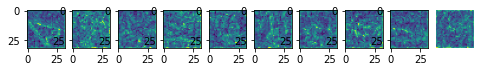

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



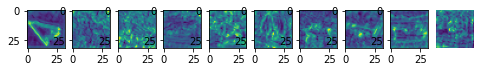

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



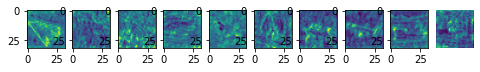

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



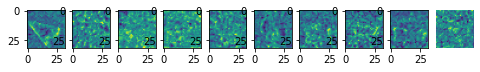

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



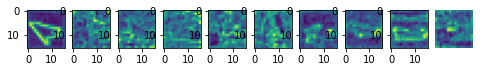

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



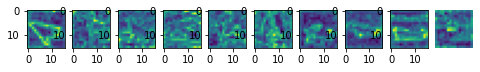

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



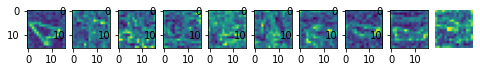

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



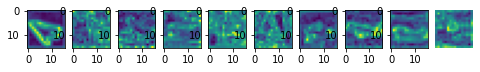

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



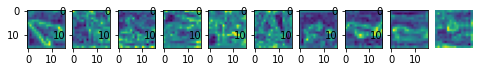

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



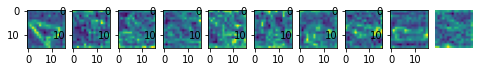

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



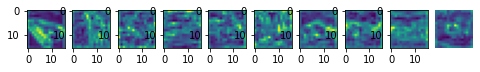

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



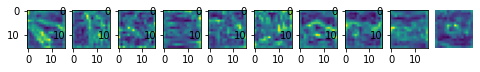

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



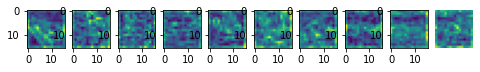

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



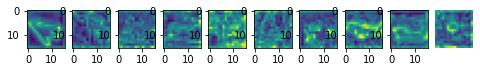

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



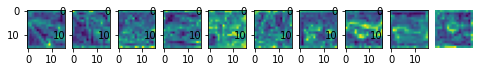

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



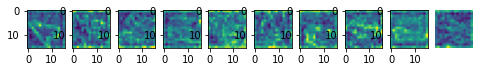

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



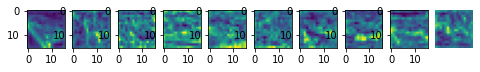

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



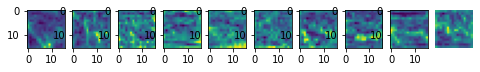

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



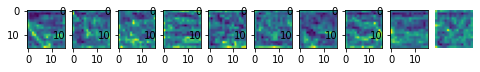

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



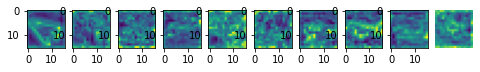

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



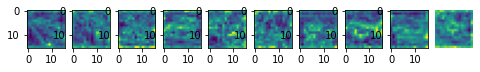

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



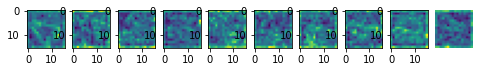

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



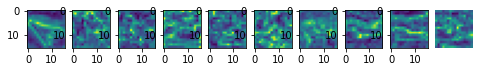

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



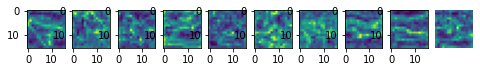

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



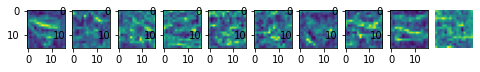

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



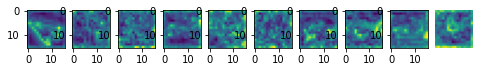

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



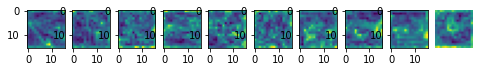

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



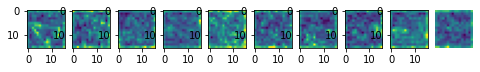

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



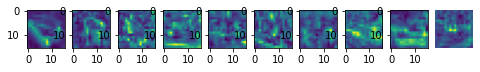

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



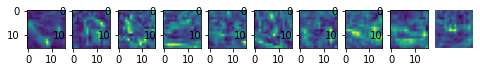

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



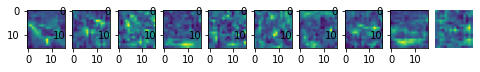

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



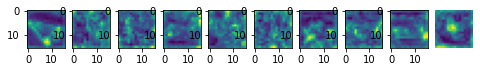

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



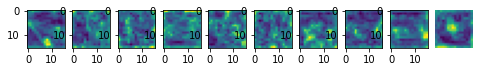

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



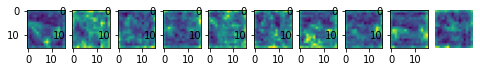

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



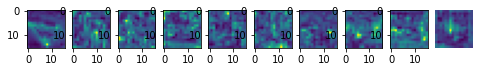

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



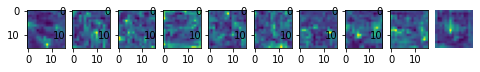

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



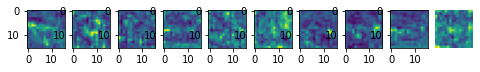

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



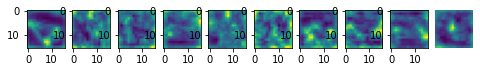

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



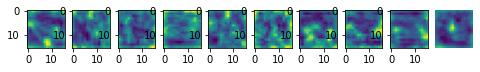

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



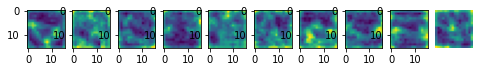

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



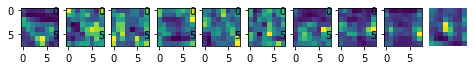

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



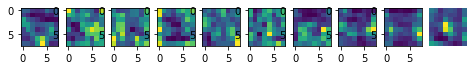

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



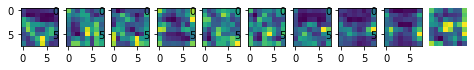

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



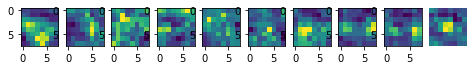

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



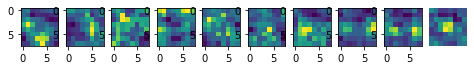

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



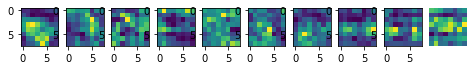

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



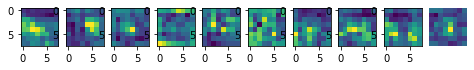

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



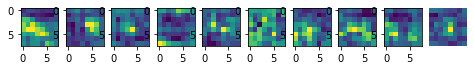

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



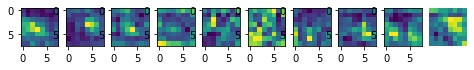

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



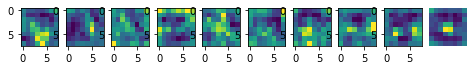

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



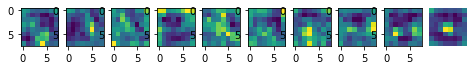

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



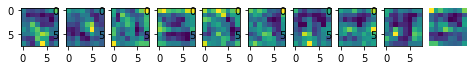

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



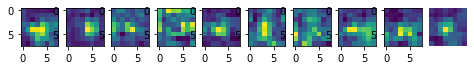

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



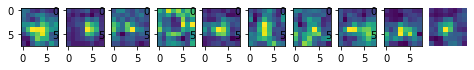

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



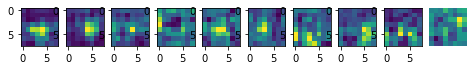

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



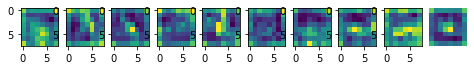

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



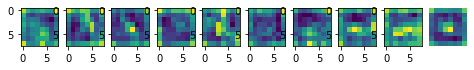

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



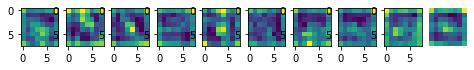

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



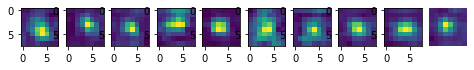

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



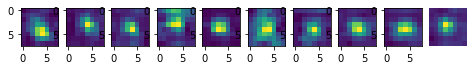

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



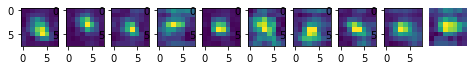

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



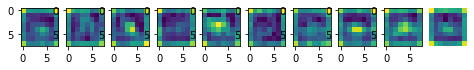

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



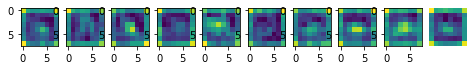

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



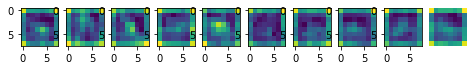

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



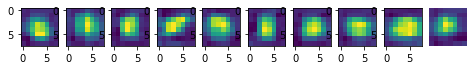

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



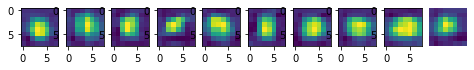

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



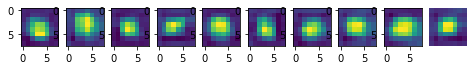

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



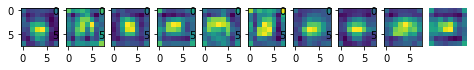

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



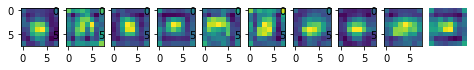

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



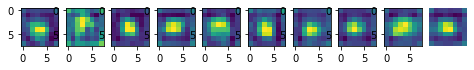

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



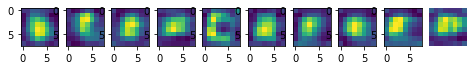

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



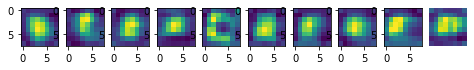

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



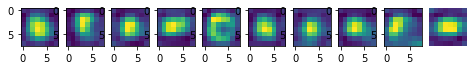

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



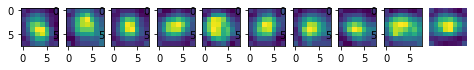

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
correct: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



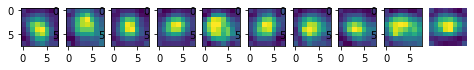

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.6132, 3.2487, 2.2115, 3.1004, 3.9127, 2.5519, 3.0974, 3.3881, 3.8512,
        2.1853], device='cuda:0')
mixed: tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
       device='cuda:0')

target: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 2], device='cuda:0')

class: 0. airplane, 1. automobile, 2. bird, 3. cat, 4. deer, 5. dog, 6. frog, 7. horse, 8. ship, 9. truck 



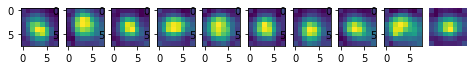

pred: tensor([0, 4, 2, 0, 7, 5, 8, 0, 8, 4], device='cuda:0')

logits: tensor([3.7011, 3.1837, 2.0732, 2.2912, 3.9528, 2.5718, 1.9320, 3.4070, 3.6638,
        1.8308], device='cuda:0')
corrupted: tensor([ True,  True,  True,  True,  True, False,  True,  True,  True, False],
       device='cuda:0')



In [30]:
plot_features(net, topic='relu')
